# King County WA, Housing Prices Classification

### Dominick Schulz, CPSC 322, 12/15/2023

This project aims to develop a classification model that can accurately predict a given house price in King County based on property characteristics and demographic information. By combining house-specific attributes with neighborhood demographics, I intend to identify key factors that influence housing prices and create a prediction model.

## Data Sources

The analysis utilizes two datasets:

1. **King County House Sales Data (from Kaggle)**: Contains approximately 20,000 house sales records with detailed property attributes including:
   - Physical characteristics (bedrooms, bathrooms, square footage, etc.)
   - Property condition and grade assessments
   - Coordinates and zipcode information
   - Sale price (classification target)

2. **U.S. Census Demographic Data (2014-2015)**: Provides demographic statistics for approximately 600 zipcodes, including:
   - Age distribution of residents
   - Racial and ethnic composition
   - Housing occupancy types (ex. owner vs. renter)
   - Educational attainment levels

These datasets were joined on zipcode, allowing each house to be associated with the demographic characteristics of its surrounding area. This combination creates a feature set for predicting housing prices, enabling analysis of both property-specific and neighborhood-specific influences.

## Classification Approach

The price variable has been discretized into 30 equal-width bins (approximately $100,000 increments) to transform the continuous price data into categorical ranges suitable for classification. After exploring various classification methods, I developed a hybrid approach that combines Naive Bayes and k-Nearest Neighbors (kNN) algorithms with appropriate weighting to optimize prediction accuracy.

Houses with prices exceeding $3,000,000 were excluded from the analysis to prevent extreme outliers from skewing the model and to enable more effective binning. The relationship between house prices and various predictors was analyzed through correlation analysis to identify the most influential features for the classification model.

Through this project, I demonstrate combining multiple classification techniques while addressing the challenges inherent in predicting real estate prices based on both property and demographic attributes.

# 2. Data Analysis

### Loading the data and combining the two tables

In [1]:
from data_table import *
from data_learn import *
from data_eval import *
from data_util import *

census_table = DataTable(['zipcode', 'occupied_units', 'owner_occupied_units', 'renter_occupied_units',
    'white_owner_occupied_units', 'white_renter_occupied_units', 'black_owner_occupied_units',
    'black_renter_occupied_units', 'american_indian_owner_occupied_units', 'american_indian_renter_occupied_units',
    'asian_owner_occupied_units', 'asian_renter_occupied_units', 'pacific_islander_owner_occupied_units',
    'pacific_islander_renter_occupied_units', 'some_other_race_owner_occupied_units',
    'some_other_race_renter_occupied_units', 'two_or_more_races_owner_occupied_units', 
    'two_or_more_races_renter_occupied_units', 'hispanic_or_latino_owner_occupied_units',
    'hispanic_or_latino_renter_occupied_units', 'white_not_hispanic_owner_occupied_units',
    'white_not_hispanic_renter_occupied_units', 'under_35_owner_occupied_units', 'under_35_renter_occupied_units',
    '35_to_44_owner_occupied_units', '35_to_44_renter_occupied_units', '45_to_54_owner_occupied_units',
    '45_to_54_renter_occupied_units', '55_to_64_owner_occupied_units', '55_to_64_renter_occupied_units',
    '65_to_74_owner_occupied_units', '65_to_74_renter_occupied_units', '75_and_over_owner_occupied_units',
    '75_and_over_renter_occupied_units', 'less_than_hs_owner_occupied_units', 'less_than_hs_renter_occupied_units',
    'high_school_grad_owner_occupied_units', 'high_school_grad_renter_occupied_units', 'some_college_owner_occupied_units',
    'some_college_renter_occupied_units', 'bachelors_or_higher_owner_occupied_units',
    'bachelors_or_higher_renter_occupied_units'
])

In [2]:
census_table.load('use_census.csv')

In [3]:
kc_table = DataTable(['date', 'price', 'bedrooms', 'bathroom', 'sqft_living', 'sqft_lot', 'floors', 'waterfront','view','condition','grade','sqft_above','sqft_base','year_built','yr_renovated','zipcode','lat','long'])
kc_table.load('use_kc_housing.csv')

In [4]:
combined_table = DataTable.combine(census_table, kc_table, ['zipcode'], False) # Does not include non matches

### Cleaning

There is very minimal cleaning necessary for these tables as there are no missing or NULL values. The main cleaning conducted was removing housing data above $3,000,000. I chose this benchmark as it still accurately represents the price distribution but eliminates outlier prices that may impact predictions. I have included visualizations below to further support this decision.

I chose to remove the outlier prices as this allowed be to create more even cut points (ie. where to cut off the binning) over the data, so I wouldn't have class labels where there were less than 5 instances present. This in turn allows for me to have a better chance at predicting the class label, but still accurately representing the data in both my training and test sets.

I also am choosing to predict the class label (price) based on some of the higher correlation variables. This is because I initially had a large number of variables to choose from and narrowing this down (to columns with significant correlation) helps prevent my model from overfitting while reducing runtime as well.

As seen below with my visualizations, 30 bins for the label column (price) still maintains an accurate representation of the distribution of house prices.

### Removing instances with a price above $3,000,000

In [5]:
revised_table = DataTable(combined_table.columns())

for row in combined_table: 
    if row['price'] < 3000000:
        revised_table.append(row.values())

### Normalizing all columns and and discretizing the price column 

In [6]:
for col in revised_table.columns():
    if col != 'price':  # adds columns to prediction list
        normalize(revised_table, col)

In [7]:
# helper function to create the cut points
def calculate_equal_width_cut_points(table, column, num_bins):
    column_values = [row[column] for row in table]

    min_value = min(column_values)
    max_value = max(column_values)

    bin_width = (max_value - min_value) / (num_bins - 1)

    cut_points = [min_value + i * bin_width for i in range(1, num_bins - 1)]

    return cut_points


In [8]:
cut_points = calculate_equal_width_cut_points(revised_table, 'price', 31)
discretize(revised_table, 'price', cut_points)

### Selecting Columns for predictions based on a correlation coeffecient above 0.1

In [9]:
correlated_cols = []
for col in combined_table.columns():
    correlation_val = correlation_coefficient(combined_table, col, 'price')
    if correlation_val > 0.1:    
        correlated_cols.append(col)
        print(f'{col} correlation: {correlation_val}')
final_table = DataTable(correlated_cols)

white_owner_occupied_units correlation: 0.12886422832827713
black_owner_occupied_units correlation: 0.17532470153264423
pacific_islander_renter_occupied_units correlation: 0.13836103919112583
some_other_race_renter_occupied_units correlation: 0.1749646513423188
55_to_64_owner_occupied_units correlation: 0.1647713112195708
55_to_64_renter_occupied_units correlation: 0.13319994796402573
65_to_74_owner_occupied_units correlation: 0.2034969159535967
75_and_over_renter_occupied_units correlation: 0.14670730352386357
price correlation: 1.0000000000000002
bedrooms correlation: 0.31542714657397053
bathroom correlation: 0.5251340727456473
sqft_living correlation: 0.7020437212325223
floors correlation: 0.2567857049754997
waterfront correlation: 0.26633051052221285
view correlation: 0.39734647437892007
grade correlation: 0.6674627402178749
sqft_above correlation: 0.6055655067254394
sqft_base correlation: 0.3238373581376776
yr_renovated correlation: 0.12644222895208526
lat correlation: 0.306918769

It is interesting and worth noting that only one zipcode demographic correlation coeffecient is above 0.2 (and just barely). It is also worth nothing that of the zipcode demographics, the only age categories that have a high correlation with price are above the age of 55.

### Creating final table with correlated columns and price

In [10]:
for row in revised_table:
    append_values = []
    for col in revised_table.columns():
        if col in correlated_cols:
            append_values.append(row[col])
    final_table.append(append_values)

### Visualizations

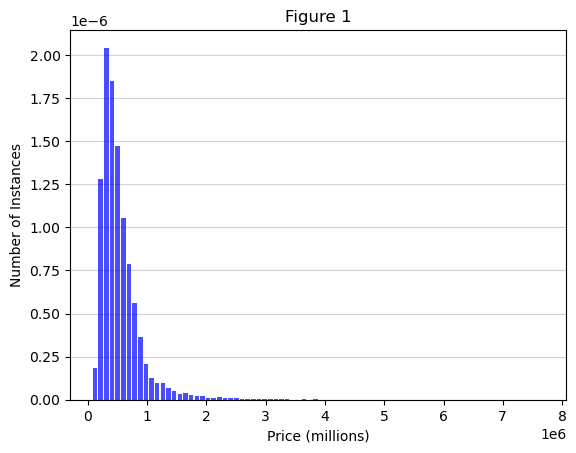

In [11]:
histogram(combined_table, 'price', 80, 'Price (millions)', 'Number of Instances', 'Figure 1')

Figure 1 displays the distriubtion of house prices in the data prior to the elimination of house prices above $3,000,000

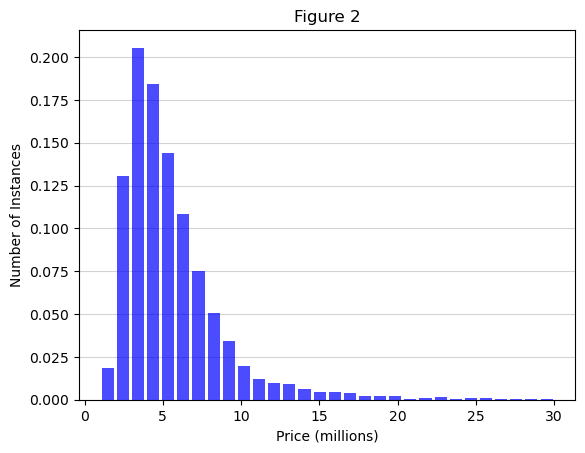

In [12]:
histogram(final_table, 'price', 30, 'Price (millions)', 'Number of Instances', 'Figure 2')

Figure 2 displays the distriubtion of house prices in the data after the elimination of house prices above $3,000,000.

**Note**: The distribution is still comparable to before creating the bins

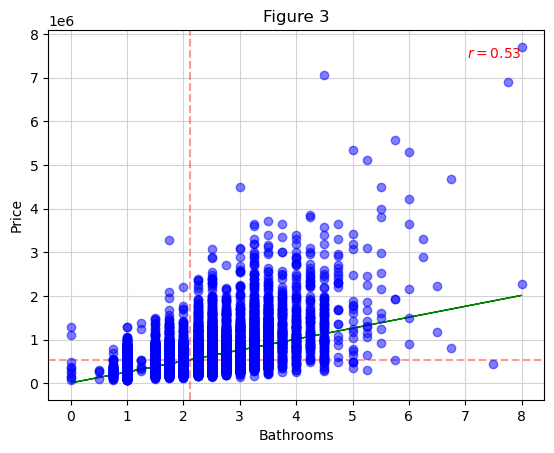

In [13]:
scatter_plot_with_best_fit(combined_table, 'bathroom', 'price', 'Bathrooms', 'Price', 'Figure 3')

Figure 3 displays the distriubtion of house prices in relation to number of bathrooms prior to the elimination of house prices above $3,000,000

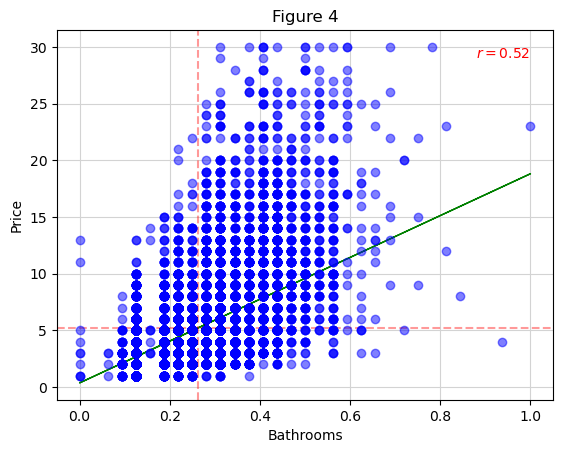

In [14]:
scatter_plot_with_best_fit(final_table, 'bathroom', 'price', 'Bathrooms', 'Price', 'Figure 4')

Figure 4 displays the distriubtion of house prices in relation to number of bathrooms prior to the elimination of house prices above $3,000,000

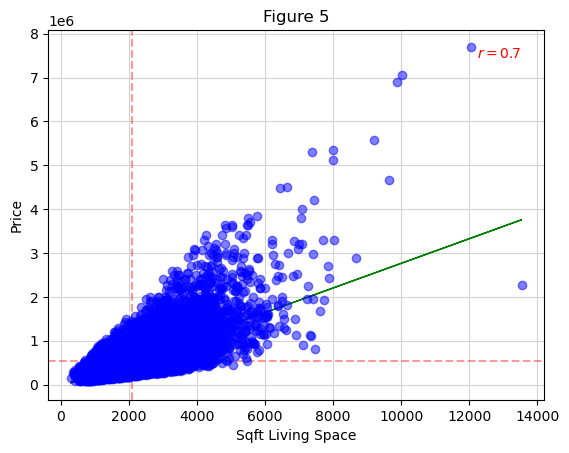

In [15]:
scatter_plot_with_best_fit(combined_table, 'sqft_living', 'price', 'Sqft Living Space', 'Price', 'Figure 5')

Figure 5 displays the distriubtion of house prices in relation to living space prior to the elimination of house prices above $3,000,000

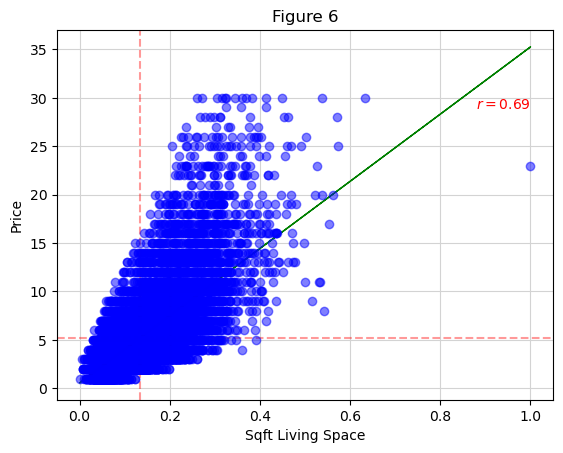

In [16]:
scatter_plot_with_best_fit(final_table, 'sqft_living', 'price', 'Sqft Living Space', 'Price', 'Figure 6')

Figure 6 displays the distriubtion of house prices in relation to living space after the elimination of house prices above $3,000,000

### Visualization Summary

As seen by the visualizations prior to and after the removal of houses with a price above $3,000,000, the correlation of the variables remains almost exactly the same (as seen by the r value). I had conducted similar visualiztions with many different variables and found similar results. This supports my decision to remove houses with a price above this benchmark as simplifying the data doesn't remove any significant trends that could potentially affect my predictions.

# 3. Classification Results

### Training and Test Split

I decided to use stratified holdout, as my algorithms are not optimized well enough to handle my data points in a timely manner (as with basic classifiers I would have them run for hours). I swapped to a size based stratified holdout (that I created in my data_eval file). This function (seen below) uses a similar approach to the origingal stratified holdout, where instead it adds the number of desired rows to both the test and training set without replacement. This function still guarantees that there is still a similar distribution to the original dataset in both the test and training sets while still controlling the train and test set size. 

In [17]:
train_set, test_set = percentage_stratified_holdout(final_table, 'price', 1600, 400)

The 'non_price_cols' list is to be used within classifier calls. This is simply a list of all columns used for classification of house prices.

In [18]:
non_price_cols = ['white_owner_occupied_units', 'black_owner_occupied_units', 
                         'pacific_islander_renter_occupied_units', 'some_other_race_renter_occupied_units', 
                         '55_to_64_owner_occupied_units', '55_to_64_renter_occupied_units', 
                         '65_to_74_owner_occupied_units', '75_and_over_renter_occupied_units', 'bedrooms', 
                         'bathroom', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_base', 
                         'yr_renovated', 'lat']

## Best Performing Simple Classifiers

kNN Classification

In [19]:
result_confusion_matrix = knn_eval(train_set, test_set, majority_vote, 5, 'price', non_price_cols)

In [20]:
calculate_averages(result_confusion_matrix)

Average Accuracy: 0.9441273779983455
Average Precision: 0.0560155133338668
Average Recall: 0.05148207368220432
Average F Measure: 0.05121787047731971


Naive Bayes Classification

In [21]:
result_confusion_matrix = naive_bayes_eval(train_set, test_set, 'price', non_price_cols)

In [22]:
calculate_averages(result_confusion_matrix)

Average Accuracy: 0.94449958643507
Average Precision: 0.04310339201883236
Average Recall: 0.04206730531186721
Average F Measure: 0.029630379234127074


Simple kNN and Naive Bayes both performed better than tdidt by itself, and the 'quality measures' (accuracy, precision, recall, and f measure) can be seen above. I did find that these 'quality measures' were better for certain price labels with naive bayes or kNN. However, when trying to implement something to handle these specific cases, I was unsuccessful in creating something to improve the average 'quality measures.' 

I really struggled with trying to find an approach to creating a tailored classifier that improved upon these basic classifications. I tried different stratified evaluations that we implemented in class along with various uses of tdidt and random forests (see note below). 

## Final Classifier - Naive Bayes and kNN Combination

In [23]:
result_confusion_matrix = naive_knn(train_set, test_set, 5, majority_vote, 'price', non_price_cols)

In [24]:
calculate_averages(result_confusion_matrix)

Average Accuracy: 0.94793217535153
Average Precision: 0.05390211132520827
Average Recall: 0.054679124581701065
Average F Measure: 0.048838063917564616


# 4. Conclusions and Future Imrovements 

I struggled with trying to find an approach that had better metrics than the basic kNN and Naive Bayes classifiers. I also ran into some other errors with this data set with my decision tree algorithms that I hadn't seen in the previous applications. There were many different discrepancies of distinct values between the test, train, and original table values because of my stratified holdout selection (which is likely causing these issues with my decision trees). Even when using a normal holdout, standard stratified holdout, or just stratify I kept running into the same issues. 

I want to reiterage my choices on how I labeled the data. Even after adjusting various binning methods and the number of bins used when discretizing the prices initially, the 30 equal width bins ended up being the most appropriate as it kept the original distribution of the data while still resulting in a larger accuracy than other bin sizes. 

### Why this ensemble classifier?

As for my final classifier, I ended up sticking with my weighted classifier (of Naive Bayes and kNN) with a k value of 5 and majority vote function. Please note that given my smaller train/test splitting method, I did run through many iterations of my classifiers to ensure I was getting consistent results when comparing them to one another. I manually adjusted the weighting and landed on Naive Bayes weighted at 0.8 and kNN weighted at 0.2 as this produced a better accuracy than both the Naive Bayes and kNN values on their own. 

The kNN classifier was the only one wwith higher metrics than my weighted ensemble. kNN's precision, recall, and f measure are higher than my weighted classifier results, but the weighted classifier accuracy was still higher than kNN alone. While the weighted classifier may appear weaker on paper due to slightly lower quality metrics, I believe the tradeoff is justified. In this context, prioritizing higher accuracy—even at the expense of a small drop in precision, recall, and F-measure—yields a more practical model. **When estimating house prices, I would rather have the predictions be more accurate across the board. Minimizing broad error is more important than optimizing class-level metrics like precision or recall.** A slightly incorrect class label may be tolerable, but wide variance in price estimates is not. Furthermore, high-end or outlier properties typically don’t rely on such models anyway, as their valuations are often already clear to homeowners or realtors (and thus less relavant for my model).

## Future improvements

Given more time and resources, I would consider the following enhancements to improve both model performance and real-world usability:

### Model Enhancements
- Alter Model Functionality: Predict continuous price values instead of classifying price ranges.
  - Adapt kNN to output averaged float values.
  - Explore neural networks for capturing complex, non-linear relationships.
- Incorporate external features:
  - Use demographic data from neighboring zip codes to capture other influences on pricing.

### API & Data Integrations
- Zillow or Realtor.com API: Pull comparable listings or current market trends.
- Google Maps API: Auto-fill neighborhood/location-based features.
- Census or city open data APIs: Join the dataset with population, income, infrastructure, and other relevant stats.

### User Interface & Deployment
- Build a web or mobile interface:
  - Users can input property details and receive instant price estimates.
- Deploy model via API:
  - Host on a cloud platform (e.g., Google Cloud, AWS, or Azure).
  - Use API endpoints to connect the UI with the backend model for real-time predictions.
